<a href="https://colab.research.google.com/github/xander-bennett/DS-Unit-2-Regression-Classification/blob/master/module3/Xander_Bennett_DS7_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) instead of Linear Regression, especially if your errors blow up! Watch [Aaron Gallant's 9 minute video on Ridge Regression](https://www.youtube.com/watch?v=XK5jkedy17w) to learn more.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
# Filtering down to the one family dwellings
df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
df.BUILDING_CLASS_CATEGORY.value_counts()

01 ONE FAMILY DWELLINGS    5061
Name: BUILDING_CLASS_CATEGORY, dtype: int64

In [5]:
# Now filtering for the sales price
# Not readable. Will remove scientific notation
df = df[(df['SALE_PRICE'] >= 100000) & 
        (df['SALE_PRICE'] < 2000000)]

df.SALE_PRICE.describe()

count    3.161000e+03
mean     6.268880e+05
std      2.940289e+05
min      1.000000e+05
25%      4.450000e+05
50%      5.650000e+05
75%      7.590000e+05
max      1.955000e+06
Name: SALE_PRICE, dtype: float64

In [6]:
# Removing scientific notation
pd.options.display.float_format = '{:,.0f}'.format

df.SALE_PRICE.describe()

count       3,161
mean      626,888
std       294,029
min       100,000
25%       445,000
50%       565,000
75%       759,000
max     1,955,000
Name: SALE_PRICE, dtype: float64

In [7]:
# Doing train/test/split
# First, I will convert to datetime and look at the data range
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    3161
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [8]:
df['SALE_DATE'].dt.month.value_counts()

1    952
3    801
2    762
4    646
Name: SALE_DATE, dtype: int64

In [9]:
test = df[df.SALE_DATE.dt.month==4]
train = df[df.SALE_DATE.dt.month<4]
train.shape, test.shape

((2515, 21), (646, 21))

In [10]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [0]:
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,nan,A9,4832 BAY PARKWAY,NaN,"11,230",1,0,1,"6,800","1,325","1,930",1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,nan,A1,80-23 232ND STREET,NaN,"11,427",1,0,1,"4,000","2,001","1,940",1,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,nan,A1,1260 RHINELANDER AVE,NaN,"10,461",1,0,1,"3,500","2,043","1,925",1,A1,810000,2019-01-02
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,nan,A1,469 E 25TH ST,NaN,"11,226",1,0,1,"4,000","2,680","1,899",1,A1,125000,2019-01-02
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,nan,A5,5521 WHITTY LANE,NaN,"11,203",1,0,1,"1,710","1,872","1,940",1,A5,620000,2019-01-02


In [13]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [14]:
train.BOROUGH.value_counts()

4    1209
5     664
3     399
2     242
1       1
Name: BOROUGH, dtype: int64

In [15]:
px.scatter(train, x='GROSS_SQUARE_FEET',y='SALE_PRICE',trendline='ols')

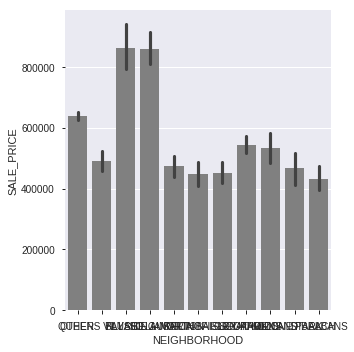

In [16]:
sns.catplot(x='NEIGHBORHOOD', y='SALE_PRICE', data=train, kind='bar', color='grey');

In [17]:
# One hot encoding. Looking for a feature that has lower cardinality.
# Which features are non-numeric?
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2515,2515,2515,2515,2515,2515,1,2515,2515,2515
unique,5,11,1,2,13,2505,1,888,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,22-40 93RD STREET,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1209,1912,2515,2484,921,2,1,235,921,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [18]:
train['BOROUGH'].value_counts()

4    1209
5     664
3     399
2     242
1       1
Name: BOROUGH, dtype: int64

In [19]:
# Check cardinality of unique values that a feature has
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2515,1,01 ONE FAMILY DWELLINGS,2515,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,2515,2,1,2484,NaN,NaN
BOROUGH,2515,5,4,1209,NaN,NaN
NEIGHBORHOOD,2515,11,OTHER,1912,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2515,11,A1,921,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2515,13,A1,921,NaN,NaN
SALE_DATE,2515,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
LAND_SQUARE_FEET,2515,888,"4,000",235,NaN,NaN
ADDRESS,2515,2505,22-40 93RD STREET,2,NaN,NaN


In [26]:
# Neighborhood seems a good fit
# Exploring Borough
# Average sale price by borough
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean()

NEIGHBORHOOD
BAYSIDE                    863,210
FLUSHING-NORTH             859,083
GREAT KILLS                544,094
LAURELTON                  473,656
MIDLAND BEACH              467,673
OTHER                      639,099
QUEENS VILLAGE             491,036
SO. JAMAICA-BAISLEY PARK   447,193
SOUTH OZONE PARK           534,469
SPRINGFIELD GARDENS        451,802
ST. ALBANS                 432,623
Name: SALE_PRICE, dtype: float64

In [23]:
train['NEIGHBORHOOD'].head()

44              OTHER
61     QUEENS VILLAGE
78              OTHER
108             OTHER
111             OTHER
Name: NEIGHBORHOOD, dtype: object

In [25]:
# Encoding this feature
import category_encoders as ce

# Instantiagte the model
encoder = ce.OneHotEncoder(use_cat_names=True)

# Fit the model
encoded = encoder.fit_transform(train['NEIGHBORHOOD'])
encoded.head()

,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_MIDLAND BEACH,NEIGHBORHOOD_ST. ALBANS
44,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,0,0,0,0,0,0
78,1,0,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,0,0,0,0,0,0


In [0]:
target = 'price'
high_cardinality